In [7]:
import json
import warnings
from itertools import chain
from typing import Callable, List, Optional
import os
import sys
import torch
from torch_geometric.data import Data, InMemoryDataset, download_url
from torch_geometric.utils import to_undirected
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch_geometric.datasets import wikics

In [8]:

notebook_path = os.getcwd()  # Get the current working directory
notebook_folder = os.path.dirname(notebook_path)  # Get the parent directory of the notebook
root = os.path.abspath(os.path.join(notebook_folder, '..', '..', 'data', 'WikiCS'))  # Construct the root path
sys.path.append('../..')  # Add the path to the script folder

from utils.transforms import Graph_to_Subgraph
dataset = wikics.WikiCS(root=root, transform=None)

In [9]:
mask_idx = 5
dataset[0].train_mask[:, mask_idx]

tensor([False, False, False,  ..., False, False,  True])

In [10]:
all_data = dataset[0]

In [11]:
all_data

Data(x=[11701, 300], edge_index=[2, 431726], y=[11701], train_mask=[11701, 20], val_mask=[11701, 20], test_mask=[11701], stopping_mask=[11701, 20])

Counter({4: 2679, 2: 2153, 3: 1933, 9: 1424, 7: 865, 5: 780, 1: 667, 8: 492, 6: 413, 0: 295})


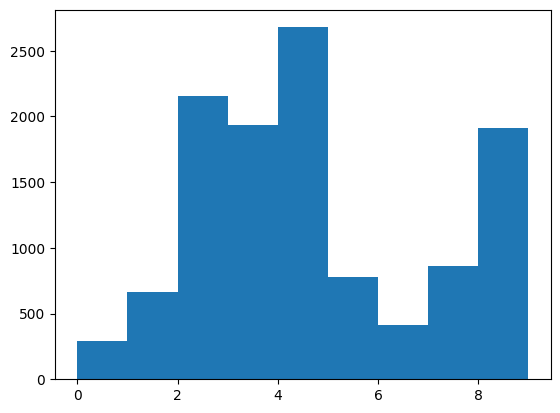

In [12]:
# Plot the histogram distributio of the labels
import matplotlib.pyplot as plt
import numpy as np
import collections

labels = all_data.y.numpy()
#labels = labels[labels != -1]
counter=collections.Counter(labels)
print(counter)
plt.hist(labels, bins=range(0, 10))
plt.show()

In [13]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

# Define the GCN model
class GCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_size, hidden_size)  # GCN layer
        self.conv2 = GCNConv(hidden_size, output_size)  # GCN layer

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)  # Apply GCN layer 1
        x = torch.relu(x)  # Apply ReLU activation
        x = self.conv2(x, edge_index)  # Apply GCN layer 2
        return x

# Define the sizes of input, hidden, and output features
input_size = 300
hidden_size = 64
output_size = 10

# Create an instance of the GCN model
gcn = GCN(input_size, hidden_size, output_size)

# Print the network architecture
print(gcn)


GCN(
  (conv1): GCNConv(300, 64)
  (conv2): GCNConv(64, 10)
)


In [14]:
# Additional function to compute accuracy
def calculate_accuracy(output, labels, mask):
    _, predicted = torch.max(output[mask], dim=1)
    correct = (predicted == labels[mask]).sum().item()
    return correct / mask.sum().item()



In [15]:
# Training loop for 10 epochs
num_epochs = 30

# Specify the mask indices for train and validation
mask_idx_train = 0
mask_idx_val = 1
train_mask = all_data.train_mask[:, mask_idx_train]
val_mask = all_data.val_mask[:, mask_idx_val]

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gcn.parameters(), lr=0.02)

# Define your validation dataset similar to the training dataset
dataset = wikics.WikiCS(root=root)

loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=False,
    num_workers=1,
)

for epoch in range(num_epochs):
    gcn.train()
    epoch_loss = 0.0

    # Training phase
    for batch in loader:
        optimizer.zero_grad()
        x, y, edge_index = batch.x, batch.y, batch.edge_index
        output = gcn(x, edge_index)
        loss = criterion(output[train_mask], y[train_mask])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Calculate training accuracy
    train_acc = calculate_accuracy(output, y, train_mask)

    # Print the average loss for the current epoch
    average_loss = epoch_loss / len(loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {average_loss:.4f}, Training Accuracy: {train_acc:.4f}")

    # Validation phase
    gcn.eval()
    with torch.no_grad():
        val_loss = 0.0
        for batch in loader:
            x, y, edge_index = batch.x, batch.y, batch.edge_index
            output = gcn(x, edge_index)
            val_loss += criterion(output[val_mask], y[val_mask]).item()

        # Calculate validation accuracy
        val_acc = calculate_accuracy(output, y, val_mask)

        average_val_loss = val_loss / len(loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

        # print a straight line to separate epochs
        print("--------------------------------------------------")


/home/tin/miniconda3/envs/Fractal/lib/python3.9/site-packages/torch_geometric/datasets/wikics.py:38: UserWarning: The WikiCS dataset now returns an undirected graph by default. Please explicitly specify 'is_undirected=False' to restore the old behavior.
  warnings.warn(


Epoch 1/30, Training Loss: 2.3078, Training Accuracy: 0.2224
Epoch 1/30, Validation Loss: 2.0575, Validation Accuracy: 0.4641
--------------------------------------------------
Epoch 2/30, Training Loss: 2.0473, Training Accuracy: 0.4707
Epoch 2/30, Validation Loss: 1.9617, Validation Accuracy: 0.3804
--------------------------------------------------
Epoch 3/30, Training Loss: 1.9356, Training Accuracy: 0.3759
Epoch 3/30, Validation Loss: 1.8725, Validation Accuracy: 0.4454
--------------------------------------------------
Epoch 4/30, Training Loss: 1.8322, Training Accuracy: 0.4793
Epoch 4/30, Validation Loss: 1.7355, Validation Accuracy: 0.5743
--------------------------------------------------
Epoch 5/30, Training Loss: 1.6862, Training Accuracy: 0.5914
Epoch 5/30, Validation Loss: 1.6345, Validation Accuracy: 0.6015
--------------------------------------------------
Epoch 6/30, Training Loss: 1.5793, Training Accuracy: 0.5983
Epoch 6/30, Validation Loss: 1.5356, Validation Accura

In [9]:
import torch
from torch_geometric.transforms import BaseTransform
class Graph_to_Subgraph(BaseTransform):
    def __init__(self, mode='fractal', depth=1, fully_connect=False):
        self.mode = mode
        self.depth = depth
        self.fully_connect = fully_connect
    def __call__(self, data):
        subgraph = Subgraph(data, mode=self.mode, depth=self.depth, fully_connect=self.fully_connect)
        return subgraph.convert_to_subgraph()

class Subgraph:
    def __init__(self, graph, mode='fractal', fully_connect=False, depth=1):
        self.device = graph.x.device
        self.num_nodes = graph.x.shape[0]
        self.subgraph = graph.clone().to(self.device)
        self.mode = mode
        self.fully_connect = fully_connect
        #TODO: not have this hardcoded
        self.crop_onehot = None # 5 is specific for QM9
        if 'transformer' in mode:
            self.mode = 'transformer'
            # split a string by underscore, for example transformer_3 into transformer and 3
            self.transformer_size = int(mode.split('_')[1])

    def convert_to_subgraph(self):
        if self.fully_connect:
            self.add_fully_connected_edges()
        self.add_subnode_features()
        self.add_subnode_forces()
        self.add_subatom_index()
        self.add_subnode_position()
        self.add_node_flags()
        self.add_subnode_edges()
        self.add_node_subnode_edges()
        self.add_subnode_node_edges()
        self.add_subgraph_batch_index()
        return self.subgraph

    def add_fully_connected_edges(self):
        # This uses fully_connect_existing_nodes from tools.py, as we want to get a fully connecte graph in a given range
        # We don't want to connect accidentally nodes that are not in the subgraph, and vice-versa
        self.subgraph.edge_index = fully_connect_existing_nodes(edge_index=self.subgraph.edge_index).to(self.device)
        #self.subgraph.subgraph_edge_index = fully_connect_existing_nodes(edge_index=self.subgraph.subgraph_edge_index).to(self.device)

    def add_subnode_features(self):
        if self.crop_onehot:
            # take only the self.crop_onehot first features
            self.subgraph.x = self.subgraph.x[:, :self.crop_onehot]
        if self.mode == 'fractal':
            self.subgraph.x = self.subgraph.x.repeat(self.num_nodes+1,1)
        self.num_features = self.subgraph.x.shape[1]
        self.total_num_nodes = self.subgraph.x.shape[0]

        if self.mode == 'transformer':
            self.subgraph.x = torch.cat([self.subgraph.x, torch.zeros(self.num_nodes, self.transformer_size).to(self.device)], dim=1)
            # create nodes for the transformer, where each node is one hot encoded to the transformer_size
            transformer_nodes = torch.eye(self.transformer_size)
            # now append zeros of the transformer_size at dimension 1
            transformer_nodes = torch.cat([torch.zeros(self.transformer_size, self.num_features), transformer_nodes], dim=1).to(self.device)
            # add transformer nodes to the subgraph for every node
            self.subgraph.x = torch.cat([self.subgraph.x, transformer_nodes.repeat(self.num_nodes,1)], dim=0)
        # Total number of nodes after adding the subgraph structure
        self.total_num_nodes = self.subgraph.x.shape[0]

    def add_subnode_position(self):
        if self.subgraph.pos is not None:
            print('Adding subnode positions')

            num_dimensions = self.subgraph.pos.shape[1]
            if self.mode == 'fractal':
                self.subgraph.pos = self.subgraph.pos.repeat(self.num_nodes+1,1)
            # In the case of the transformer, the position has no interpretable meaning so we don't se it.
            elif self.mode == 'transformer':
                # Fill up subgraph.pos for the new nodes with the positions of the node they belong to
                self.subgraph.pos = torch.cat([self.subgraph.pos, self.subgraph.pos.repeat_interleave(self.transformer_size, dim=0)], dim=0)

                #self.subgraph.pos = torch.cat([self.subgraph.pos, torch.zeros(self.total_num_nodes-self.num_nodes, num_dimensions).to(self.device)], dim=0)
                # asser that subgraph pos[0] is equal to total num of nodes
                assert self.subgraph.pos.shape[0] == self.total_num_nodes


    def add_subnode_forces(self):
        if hasattr(self.subgraph, 'force'):
            if self.mode == 'fractal':
                self.subgraph.force = self.subgraph.force.repeat(self.num_nodes+1,1)
            elif self.mode == 'transformer':
                # do same as for positions
                self.subgraph.force = torch.cat([self.subgraph.force, torch.zeros(self.total_num_nodes-self.num_nodes, 3).to(self.device)], dim=0)
                assert self.subgraph.force.shape[0] == self.total_num_nodes

    def add_node_flags(self):
        if hasattr(self.subgraph, 'x'):
            self.subgraph.ground_node = torch.arange(self.subgraph.x.shape[0]) < self.num_nodes
        else:
            raise ValueError('No node features found. Please add node features first.')

    def add_subnode_edges(self):
        if self.mode == 'fractal':
            self.subgraph.subgraph_edge_index = self.subgraph.edge_index + self.num_nodes
            for subg in range(self.num_nodes-1):
                #TODO: Check if this is correct
                self.subgraph.subgraph_edge_index = torch.cat([self.subgraph.subgraph_edge_index,
                                                               self.subgraph.edge_index + self.num_nodes + (subg+1)*self.num_nodes],
                                                              dim=1)
        elif self.mode == 'transformer':
            # create a fully connected edge index for the transformer of size transformer_size
            transformer_edge_index = torch.stack([torch.arange(self.transformer_size).repeat_interleave(self.transformer_size),
                                                  torch.arange(self.transformer_size).repeat(self.transformer_size)],
                                                 dim=0).to(self.device)
            self.subgraph.subgraph_edge_index = transformer_edge_index + self.num_nodes
            for subg in range(self.num_nodes-1):
                #TODO: Check if this is correct
                self.subgraph.subgraph_edge_index = torch.cat([self.subgraph.subgraph_edge_index,
                                                               transformer_edge_index  + self.num_nodes + (subg+1)*self.transformer_size],
                                                              dim=1).to(self.device)
    def add_node_subnode_edges(self):
        if self.mode == 'fractal':
            self.subgraph.node_subnode_index = torch.stack([torch.arange(self.num_nodes).repeat_interleave(self.num_nodes),
                                                            torch.arange(self.num_nodes, self.total_num_nodes)],
                                                           dim=0).to(self.device)
        elif self.mode == 'transformer':
            self.subgraph.node_subnode_index = torch.stack([torch.arange(self.num_nodes).repeat_interleave(self.transformer_size),
                                                            torch.arange(self.num_nodes, self.total_num_nodes)],
                                                           dim=0).to(self.device)

    def add_subnode_node_edges(self):
        if self.mode == 'fractal':
            self.subgraph.subnode_node_index = torch.stack([torch.arange(self.num_nodes, self.total_num_nodes), torch.arange(self.num_nodes).repeat_interleave(self.num_nodes)], dim=0)
        elif self.mode == 'transformer':
            self.subgraph.subnode_node_index = torch.stack([torch.arange(self.num_nodes, self.total_num_nodes),
                                                            torch.arange(self.num_nodes).repeat_interleave(self.transformer_size)],
                                                           dim=0).to(self.device)

    def add_subgraph_batch_index(self):
        if self.mode == 'fractal':
            self.subgraph.subgraph_batch_index = torch.arange(self.num_nodes).repeat_interleave(self.num_nodes)
        elif self.mode == 'transformer':
            self.subgraph.subgraph_batch_index = torch.arange(self.num_nodes).repeat_interleave(self.transformer_size)

    def add_subatom_index(self):
        if self.mode == 'fractal':
            self.subgraph.subatom_index = torch.arange(self.num_nodes).repeat(self.num_nodes+1)

In [10]:
transforms = Graph_to_Subgraph(mode='transformer_5')
dataset = wikics.WikiCS(root=root, transform=transforms)
dataset[0]

Data(x=[70206, 305], edge_index=[2, 431726], y=[11701], train_mask=[11701, 20], val_mask=[11701, 20], test_mask=[11701], stopping_mask=[11701, 20], ground_node=[70206], subgraph_edge_index=[2, 292525], node_subnode_index=[2, 58505], subnode_node_index=[2, 58505], subgraph_batch_index=[58505])

In [11]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.functional as F
# Define the GCN model
class Transformer_GCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Transformer_GCN, self).__init__()
        self.mask = True
        self.ground_conv1 = GCNConv(input_size, hidden_size)  # GCN layer
        self.ground_conv2 = GCNConv(hidden_size, hidden_size)  # GCN layer
        self.gts_conv1 = GCNConv(hidden_size, hidden_size)  # GCN layer
        self.gts_conv2 = GCNConv(hidden_size, hidden_size)  # GCN layer
        self.sub_conv1 = GCNConv(hidden_size, hidden_size)  # GCN layer
        self.sub_conv2 = GCNConv(hidden_size, hidden_size)  # GCN layer
        self.stg_conv1 = GCNConv(hidden_size, hidden_size)  # GCN layer
        self.stg_conv2 = GCNConv(hidden_size, output_size)  # GCN layer

    def forward(self, batch):
        x, edge_index, _ = batch.x, batch.edge_index, batch.batch
        node_subnode_index = batch.node_subnode_index
        subgraph_edge_index = batch.subgraph_edge_index
        subnode_node_index = batch.subnode_node_index

        x = self.ground_conv1(x, edge_index)
        x = torch.relu(x)
        x = self.gts_conv1(x, node_subnode_index)
        x = torch.relu(x)
        x = self.sub_conv1(x, subgraph_edge_index)
        x = torch.relu(x)
        x = self.stg_conv1(x, subnode_node_index)
        x = torch.relu(x)
        x = self.ground_conv2(x, edge_index)
        x = torch.relu(x)
        x = self.gts_conv2(x, node_subnode_index)
        x = torch.relu(x)
        x = self.sub_conv2(x, subgraph_edge_index)
        x = torch.relu(x)
        x = self.stg_conv2(x, subnode_node_index)

        return x

# Define the sizes of input, hidden, and output features
input_size = 305
hidden_size = 64
output_size = 10

# Create an instance of the GCN model
gcn = Transformer_GCN(input_size, hidden_size, output_size)

# Print the network architecture
print(gcn)


Transformer_GCN(
  (ground_conv1): GCNConv(305, 64)
  (ground_conv2): GCNConv(64, 64)
  (gts_conv1): GCNConv(64, 64)
  (gts_conv2): GCNConv(64, 64)
  (sub_conv1): GCNConv(64, 64)
  (sub_conv2): GCNConv(64, 64)
  (stg_conv1): GCNConv(64, 64)
  (stg_conv2): GCNConv(64, 10)
)


In [12]:
# Training loop for 10 epochs
num_epochs = 100

# Specify the mask indices for train and validation
mask_idx_train = 0
mask_idx_val = 1
train_mask = all_data.train_mask[:, mask_idx_train]
val_mask = all_data.val_mask[:, mask_idx_val]

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gcn.parameters(), lr=0.003)

# Define your validation dataset similar to the training dataset


transforms = Graph_to_Subgraph(mode='transformer_5')
dataset = wikics.WikiCS(root=root, transform=transforms)
loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=False,
    num_workers=1
)

for epoch in range(num_epochs):
    gcn.train()
    epoch_loss = 0.0

    # Training phase
    for batch in loader:
        optimizer.zero_grad()
        x, y, edge_index = batch.x, batch.y, batch.edge_index
        output = gcn(batch)
        output, y = output[batch.ground_node], y
        loss = criterion(output[train_mask], y[train_mask])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Calculate training accuracy
    train_acc = calculate_accuracy(output, y, train_mask)

    # Print the average loss for the current epoch
    average_loss = epoch_loss / len(loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {average_loss:.4f}, Training Accuracy: {train_acc:.4f}")

    # Validation phase
    gcn.eval()
    with torch.no_grad():
        val_loss = 0.0
        for batch in loader:
            x, y, edge_index = batch.x, batch.y, batch.edge_index
            output = gcn(batch)
            output, y = output[batch.ground_node], y
            val_loss += criterion(output[val_mask], y[val_mask]).item()

        # Calculate validation accuracy
        val_acc = calculate_accuracy(output, y, val_mask)

        average_val_loss = val_loss / len(loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

        # print a straight line to separate epochs
        print("--------------------------------------------------")

Epoch 1/100, Training Loss: 2.3143, Training Accuracy: 0.0241
Epoch 1/100, Validation Loss: 2.2763, Validation Accuracy: 0.0786
--------------------------------------------------
Epoch 2/100, Training Loss: 2.2748, Training Accuracy: 0.0897
Epoch 2/100, Validation Loss: 2.2305, Validation Accuracy: 0.1860
--------------------------------------------------
Epoch 3/100, Training Loss: 2.2268, Training Accuracy: 0.1862
Epoch 3/100, Validation Loss: 2.1726, Validation Accuracy: 0.2109
--------------------------------------------------
Epoch 4/100, Training Loss: 2.1664, Training Accuracy: 0.2121
Epoch 4/100, Validation Loss: 2.1167, Validation Accuracy: 0.1877
--------------------------------------------------
Epoch 5/100, Training Loss: 2.1052, Training Accuracy: 0.1931
Epoch 5/100, Validation Loss: 2.0839, Validation Accuracy: 0.1854
--------------------------------------------------
Epoch 6/100, Training Loss: 2.0645, Training Accuracy: 0.1931
Epoch 6/100, Validation Loss: 2.0542, Valid